In [2]:
# Basics
import sys
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Sklearn
from sklearn.preprocessing import StandardScaler, Imputer 
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import cross_val_score, ShuffleSplit
from sklearn.learning_curve import learning_curve, validation_curve
from sklearn.metrics import make_scorer
# xgboost
import xgboost as xgb
# Our custom modules
sys.path.append('..')
from anrg.pipeline import Pipeline # my customized Pipeline
from anrg.blending import BlendedRegressor
from anrg.cleaning import TargetThresholdFilter, LogPlusOne
##### setting #######
pd.set_option('display.max_columns', 500)  # force pandas to display all columns for better visual inspection
%matplotlib inline

In [3]:
trn = pd.read_csv('../data/train.csv')
# trn = pd.read_csv('../data/train_10.csv', index_col=0)  # column #0 in our file is DataFrame index
# trn = pd.read_csv('../data/train_1.csv', index_col=0)

In [4]:
t = time.time()
trn_withRef = trn[trn['Ref'].notnull()]
print 'Time elapsed: {:.4f} secs'.format(time.time()-t)  # toc

Time elapsed: 0.4343 secs


In [5]:
# Combine observations by 'Id', aggregate features
t = time.time()
trn_withRef_comb = trn_withRef.groupby('Id').agg(['mean','std','median','count','min', 'max'])
trn_withRef_comb.columns = ['_'.join(tup) for (i,tup) in enumerate(trn_withRef_comb.columns.values)]
trn_withRef_comb = trn_withRef_comb.drop(['Expected_count', 'Expected_median', 'Expected_std', 'Expected_min','Expected_max'], axis =1)
print 'Time elapsed: {:.4f} secs'.format(time.time()-t)  # toc

Time elapsed: 7.4513 secs


In [6]:
X = trn_withRef_comb.loc[:, 'minutes_past_mean':'Kdp_5x5_90th_max']  # NOTE: used range slicing on column
y = trn_withRef_comb['Expected_mean']
print X.shape, y.shape

(731556, 132) (731556,)


In [7]:
ttf = TargetThresholdFilter(threshold=45)
lpo = LogPlusOne()
imp = Imputer(strategy='median', copy=False)  # Get a imputor with column-mean filling config
ss = StandardScaler(copy=False, with_mean=True, with_std=True)
clf = RandomForestRegressor(n_estimators=500, max_features=0.2, max_depth=25, n_jobs=6)
pip = Pipeline([('ttf',ttf), ('lpo',lpo), ('imp',imp), ('ss',ss), ('clf',clf)])  # a Pipeline wrapper to chain'em up
def LogPlusOne_score(ground_truth, predictions, lpo=lpo):
    return np.float64(np.mean(np.abs(ground_truth - (np.power(10, predictions) - 1))))
scorer = make_scorer(LogPlusOne_score, greater_is_better=True)  # define scoring metric

# CV

In [8]:
scores = cross_val_score(estimator=pip, X=X, y=y, scoring=scorer, cv=10, n_jobs=1, verbose=1)

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 196.1min finished


In [9]:
print np.mean(scores), np.std(scores)
pip.get_params()['steps']

23.0916161025 1.58077730629


Pipeline(steps=[('ttf', TargetThresholdFilter(threshold=45)), ('lpo', LogPlusOne()), ('imp', Imputer(axis=0, copy=False, missing_values='NaN', strategy='median',
    verbose=0)), ('ss', StandardScaler(copy=False, with_mean=True, with_std=True)), ('clf', RandomForestRegressor(bootstrap=True, criterion='mse', ...imators=500, n_jobs=6, oob_score=False, random_state=None,
           verbose=0, warm_start=False))])

In [8]:
print np.mean(scores), np.std(scores)
pip

23.0983610288 1.58061776579


Pipeline(steps=[('ttf', TargetThresholdFilter(threshold=45)), ('lpo', LogPlusOne()), ('imp', Imputer(axis=0, copy=False, missing_values='NaN', strategy='median',
    verbose=0)), ('ss', StandardScaler(copy=False, with_mean=True, with_std=True)), ('clf', RandomForestRegressor(bootstrap=True, criterion='mse', ...imators=100, n_jobs=6, oob_score=False, random_state=None,
           verbose=0, warm_start=False))])

In [9]:
# Sweep parameter
param_name, param_range='clf__max_features', np.arange(0.1, 0.5, 0.1)
train_scores, test_scores= validation_curve(estimator=pip, X=X, y=y, scoring=scorer, cv=10, n_jobs=1, 
                          param_name=param_name, param_range=param_range, verbose=2)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

[CV] clf__max_features=0.1 ...........................................
[CV] .................................. clf__max_features=0.1 - 2.2min
[CV] clf__max_features=0.2 ...........................................
[CV] .................................. clf__max_features=0.2 - 3.8min
[CV] clf__max_features=0.3 ...........................................
[CV] .................................. clf__max_features=0.3 - 5.4min
[CV] clf__max_features=0.4 ...........................................
[CV] .................................. clf__max_features=0.4 - 7.0min
[CV] clf__max_features=0.1 ...........................................
[CV] .................................. clf__max_features=0.1 - 2.2min
[CV] clf__max_features=0.2 ...........................................
[CV] .................................. clf__max_features=0.2 - 3.9min
[CV] clf__max_features=0.3 ...........................................
[CV] .................................. clf__max_features=0.3 - 5.7min
[CV] c

[Parallel(n_jobs=1)]: Done  40 tasks       | elapsed: 198.1min
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed: 198.1min finished


# Diff tree depth, sweep max feature, 10 tree

[('ttf', TargetThresholdFilter(threshold=45)), ('lpo', LogPlusOne()), ('imp', Imputer(axis=0, copy=False, missing_values='NaN', strategy='median',
    verbose=0)), ('ss', StandardScaler(copy=False, with_mean=True, with_std=True)), ('clf', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=3,
           max_features=0.95000000000000029, max_leaf_nodes=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=6,
           oob_score=False, random_state=None, verbose=0, warm_start=False))]
[ 0.1   0.15  0.2   0.25  0.3   0.35  0.4   0.45  0.5   0.55  0.6   0.65
  0.7   0.75  0.8   0.85  0.9   0.95]
[ 16.95584331  16.95095649  16.94766924  16.94697379  16.94622832
  16.94490122  16.94523639  16.94542607  16.94481136  16.94444689
  16.94479091  16.94483894  16.94472786  16.94446076  16.94442455
  16.94449839  16.94398974  16.9441655 ]
[ 16.9599598   16.95562989  16.95193004  16.95240322  16.9504839
  16.95112121 

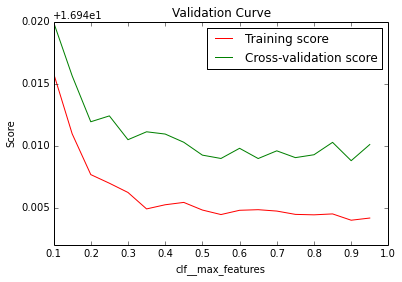

In [30]:
### Plotting the validation curver, i.e. trn/val error versus parameter value
print pip.get_params()['steps']
print param_range
print train_scores_mean
print test_scores_mean
plt.title("Validation Curve")
plt.xlabel(param_name)
plt.ylabel("Score")
plt.plot(param_range, train_scores_mean, label="Training score", color="r")
# plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color="r")
plt.plot(param_range, test_scores_mean, label="Cross-validation score", color="g")
# plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.2, color="g")
plt.legend(loc="best")
plt.show()

[('ttf', TargetThresholdFilter(threshold=45)), ('lpo', LogPlusOne()), ('imp', Imputer(axis=0, copy=False, missing_values='NaN', strategy='median',
    verbose=0)), ('ss', StandardScaler(copy=False, with_mean=True, with_std=True)), ('clf', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features=0.95000000000000029, max_leaf_nodes=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=6,
           oob_score=False, random_state=None, verbose=0, warm_start=False))]
[ 0.1   0.15  0.2   0.25  0.3   0.35  0.4   0.45  0.5   0.55  0.6   0.65
  0.7   0.75  0.8   0.85  0.9   0.95]
[ 16.92367166  16.91855029  16.91666588  16.91375024  16.91374008
  16.91277658  16.91231085  16.91256445  16.91200823  16.91208682
  16.91137378  16.9113408   16.91152224  16.91133806  16.91121212
  16.91112899  16.91122187  16.9111153 ]
[ 16.93613011  16.93131493  16.93077141  16.92779152  16.92818587
  16.92733435

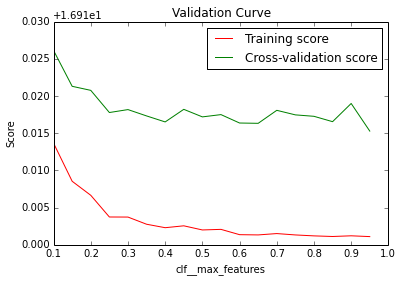

In [27]:
### Plotting the validation curver, i.e. trn/val error versus parameter value
# max_depth = 5
# 1% data
print pip.get_params()['steps']
print param_range
print train_scores_mean
print test_scores_mean
plt.title("Validation Curve")
plt.xlabel(param_name)
plt.ylabel("Score")
plt.plot(param_range, train_scores_mean, label="Training score", color="r")
# plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color="r")
plt.plot(param_range, test_scores_mean, label="Cross-validation score", color="g")
# plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.2, color="g")
plt.legend(loc="best")
plt.show()

[('ttf', TargetThresholdFilter(threshold=45)), ('lpo', LogPlusOne()), ('imp', Imputer(axis=0, copy=False, missing_values='NaN', strategy='median',
    verbose=0)), ('ss', StandardScaler(copy=False, with_mean=True, with_std=True)), ('clf', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=7,
           max_features=0.95000000000000029, max_leaf_nodes=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=6,
           oob_score=False, random_state=None, verbose=0, warm_start=False))]
[ 0.1   0.15  0.2   0.25  0.3   0.35  0.4   0.45  0.5   0.55  0.6   0.65
  0.7   0.75  0.8   0.85  0.9   0.95]
[ 16.88777208  16.88185136  16.87818636  16.87543707  16.8743078
  16.87324644  16.87290535  16.87255146  16.87182442  16.87135279
  16.87047544  16.87116341  16.87081014  16.87096874  16.87025326
  16.86938898  16.87093263  16.87128058]
[ 16.92621814  16.92348176  16.92128485  16.91924131  16.91941982
  16.92026058 

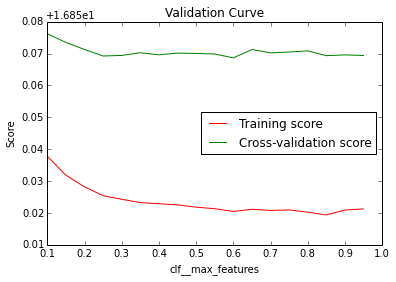

In [33]:
### Plotting the validation curver, i.e. trn/val error versus parameter value
# max_depth = 7
# 1% data
print pip.get_params()['steps']
print param_range
print train_scores_mean
print test_scores_mean
plt.title("Validation Curve")
plt.xlabel(param_name)
plt.ylabel("Score")
plt.plot(param_range, train_scores_mean, label="Training score", color="r")
# plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color="r")
plt.plot(param_range, test_scores_mean, label="Cross-validation score", color="g")
# plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.2, color="g")
plt.legend(loc="best")
plt.show()

[('ttf', TargetThresholdFilter(threshold=45)), ('lpo', LogPlusOne()), ('imp', Imputer(axis=0, copy=False, missing_values='NaN', strategy='median',
    verbose=0)), ('ss', StandardScaler(copy=False, with_mean=True, with_std=True)), ('clf', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=0.95000000000000029, max_leaf_nodes=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=6,
           oob_score=False, random_state=None, verbose=0, warm_start=False))]
[ 0.1   0.15  0.2   0.25  0.3   0.35  0.4   0.45  0.5   0.55  0.6   0.65
  0.7   0.75  0.8   0.85  0.9   0.95]
[ 15.58822172  15.58944319  15.59116968  15.59165687  15.58969854
  15.5887155   15.58905277  15.58930666  15.58907375  15.58954133
  15.59210796  15.59188672  15.59057988  15.58762041  15.58892294
  15.59094633  15.59131488  15.58831281]
[ 17.02935486  17.03522062  17.04850154  17.04044211  17.04415569
  17.04772

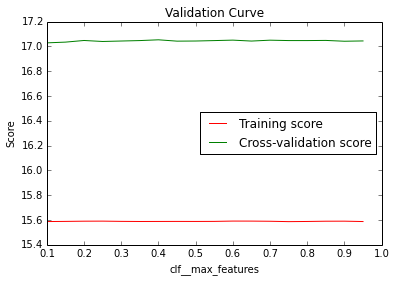

In [9]:
# Plotting the validation curver, i.e. trn/val error versus parameter value
# max_depth = None
# 1% data
print pip.get_params()['steps']
print param_range
print train_scores_mean
print test_scores_mean
plt.title("Validation Curve")
plt.xlabel(param_name)
plt.ylabel("Score")
plt.plot(param_range, train_scores_mean, label="Training score", color="r")
# plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color="r")
plt.plot(param_range, test_scores_mean, label="Cross-validation score", color="g")
# plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.2, color="g")
plt.legend(loc="best")
plt.show()

# Diff tree depth, sweep max feature, 100 tree

[('ttf', TargetThresholdFilter(threshold=45)), ('lpo', LogPlusOne()), ('imp', Imputer(axis=0, copy=False, missing_values='NaN', strategy='median',
    verbose=0)), ('ss', StandardScaler(copy=False, with_mean=True, with_std=True)), ('clf', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=3,
           max_features=0.95000000000000029, max_leaf_nodes=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=6,
           oob_score=False, random_state=None, verbose=0, warm_start=False))]
[ 0.1   0.15  0.2   0.25  0.3   0.35  0.4   0.45  0.5   0.55  0.6   0.65
  0.7   0.75  0.8   0.85  0.9   0.95]
[ 16.95464435  16.94895328  16.94655828  16.94509542  16.94450263
  16.94379623  16.94368894  16.94354407  16.94347292  16.94342644
  16.94315204  16.94329682  16.94322417  16.94306829  16.94311691
  16.9431415   16.94314616  16.94325834]
[ 16.95899005  16.953131    16.95112153  16.9496364   16.94918228
  16.9482478

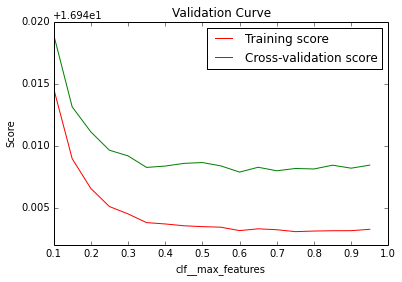

In [12]:
# Plotting the validation curver, i.e. trn/val error versus parameter value
# max_depth = 3
# 1% data
print pip.get_params()['steps']
print param_range
print train_scores_mean
print test_scores_mean
plt.title("Validation Curve")
plt.xlabel(param_name)
plt.ylabel("Score")
plt.plot(param_range, train_scores_mean, label="Training score", color="r")
# plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color="r")
plt.plot(param_range, test_scores_mean, label="Cross-validation score", color="g")
# plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.2, color="g")
plt.legend(loc="best")
plt.show()

[('ttf', TargetThresholdFilter(threshold=45)), ('lpo', LogPlusOne()), ('imp', Imputer(axis=0, copy=False, missing_values='NaN', strategy='median',
    verbose=0)), ('ss', StandardScaler(copy=False, with_mean=True, with_std=True)), ('clf', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features=0.95000000000000029, max_leaf_nodes=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=6,
           oob_score=False, random_state=None, verbose=0, warm_start=False))]
[ 0.1   0.15  0.2   0.25  0.3   0.35  0.4   0.45  0.5   0.55  0.6   0.65
  0.7   0.75  0.8   0.85  0.9   0.95]
[ 16.92232592  16.91704234  16.91429958  16.91280947  16.91189117
  16.91142653  16.91102845  16.91075643  16.91066839  16.91043913
  16.91035645  16.91016854  16.91015312  16.91000118  16.9097485
  16.90986562  16.90978905  16.9097888 ]
[ 16.93449807  16.93046618  16.92831075  16.92708333  16.92671927
  16.92633991

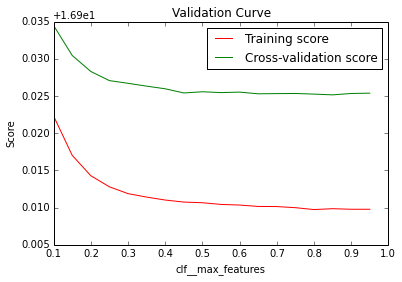

In [15]:
# Plotting the validation curver, i.e. trn/val error versus parameter value
# max_depth = 5
# 1% data
print pip.get_params()['steps']
print param_range
print train_scores_mean
print test_scores_mean
plt.title("Validation Curve")
plt.xlabel(param_name)
plt.ylabel("Score")
plt.plot(param_range, train_scores_mean, label="Training score", color="r")
# plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color="r")
plt.plot(param_range, test_scores_mean, label="Cross-validation score", color="g")
# plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.2, color="g")
plt.legend(loc="best")
plt.show()

[('ttf', TargetThresholdFilter(threshold=45)), ('lpo', LogPlusOne()), ('imp', Imputer(axis=0, copy=False, missing_values='NaN', strategy='median',
    verbose=0)), ('ss', StandardScaler(copy=False, with_mean=True, with_std=True)), ('clf', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=7,
           max_features=0.95000000000000029, max_leaf_nodes=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=6,
           oob_score=False, random_state=None, verbose=0, warm_start=False))]
[ 0.1   0.15  0.2   0.25  0.3   0.35  0.4   0.45  0.5   0.55  0.6   0.65
  0.7   0.75  0.8   0.85  0.9   0.95]
[ 16.88485115  16.87878217  16.87527169  16.87324877  16.8717604
  16.87081669  16.86996705  16.86952643  16.86903414  16.86890807
  16.86837888  16.86827366  16.86804605  16.86793871  16.86746918
  16.86758669  16.86744058  16.86732748]
[ 16.92269327  16.91872055  16.91758499  16.9168937   16.9166809
  16.91680553 

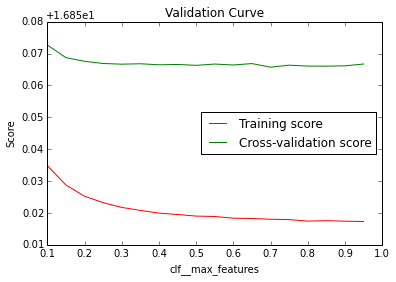

In [18]:
# Plotting the validation curver, i.e. trn/val error versus parameter value
# max_depth = 7
# 1% data
print pip.get_params()['steps']
print param_range
print train_scores_mean
print test_scores_mean
plt.title("Validation Curve")
plt.xlabel(param_name)
plt.ylabel("Score")
plt.plot(param_range, train_scores_mean, label="Training score", color="r")
# plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color="r")
plt.plot(param_range, test_scores_mean, label="Cross-validation score", color="g")
# plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.2, color="g")
plt.legend(loc="best")
plt.show()

[('ttf', TargetThresholdFilter(threshold=45)), ('lpo', LogPlusOne()), ('imp', Imputer(axis=0, copy=False, missing_values='NaN', strategy='median',
    verbose=0)), ('ss', StandardScaler(copy=False, with_mean=True, with_std=True)), ('clf', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features=0.95000000000000029, max_leaf_nodes=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=6,
           oob_score=False, random_state=None, verbose=0, warm_start=False))]
[ 0.1   0.15  0.2   0.25  0.3   0.35  0.4   0.45  0.5   0.55  0.6   0.65
  0.7   0.75  0.8   0.85  0.9   0.95]
[ 16.78452827  16.77353875  16.76732166  16.76226426  16.76029314
  16.75756111  16.7564013   16.75496952  16.75378936  16.75309343
  16.75239764  16.75241233  16.75160271  16.75072896  16.75084939
  16.75029901  16.75012703  16.75017323]
[ 16.91568351  16.91367055  16.91223927  16.91315884  16.91321416  16.91365
 

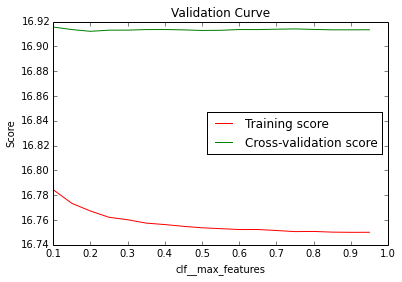

In [21]:
# Plotting the validation curver, i.e. trn/val error versus parameter value
# max_depth = 10
# 1% data
print pip.get_params()['steps']
print param_range
print train_scores_mean
print test_scores_mean
plt.title("Validation Curve")
plt.xlabel(param_name)
plt.ylabel("Score")
plt.plot(param_range, train_scores_mean, label="Training score", color="r")
# plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color="r")
plt.plot(param_range, test_scores_mean, label="Cross-validation score", color="g")
# plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.2, color="g")
plt.legend(loc="best")
plt.show()

[('ttf', TargetThresholdFilter(threshold=45)), ('lpo', LogPlusOne()), ('imp', Imputer(axis=0, copy=False, missing_values='NaN', strategy='median',
    verbose=0)), ('ss', StandardScaler(copy=False, with_mean=True, with_std=True)), ('clf', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='sqrt', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=6, oob_score=False, random_state=None,
           verbose=0, warm_start=False))]
[ 0.1   0.15  0.2   0.25  0.3   0.35  0.4   0.45  0.5   0.55  0.6   0.65
  0.7   0.75  0.8   0.85  0.9   0.95]
[ 16.78452827  16.77353875  16.76732166  16.76226426  16.76029314
  16.75756111  16.7564013   16.75496952  16.75378936  16.75309343
  16.75239764  16.75241233  16.75160271  16.75072896  16.75084939
  16.75029901  16.75012703  16.75017323]
[ 16.91568351  16.91367055  16.91223927  16.91315884  16.91321416  16.91365
  16.9137015

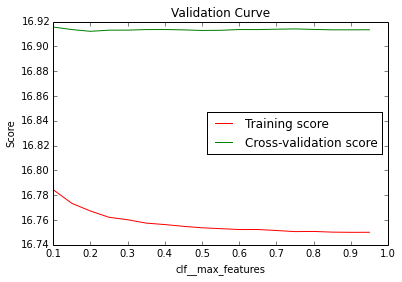

In [23]:
# Plotting the validation curver, i.e. trn/val error versus parameter value
# max_depth = None
# 1% data
print pip.get_params()['steps']
print param_range
print train_scores_mean
print test_scores_mean
plt.title("Validation Curve")
plt.xlabel(param_name)
plt.ylabel("Score")
plt.plot(param_range, train_scores_mean, label="Training score", color="r")
# plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color="r")
plt.plot(param_range, test_scores_mean, label="Cross-validation score", color="g")
# plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.2, color="g")
plt.legend(loc="best")
plt.show()

[('ttf', TargetThresholdFilter(threshold=45)), ('lpo', LogPlusOne()), ('imp', Imputer(axis=0, copy=False, missing_values='NaN', strategy='median',
    verbose=0)), ('ss', StandardScaler(copy=False, with_mean=True, with_std=True)), ('clf', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=25,
           max_features=0.40000000000000002, max_leaf_nodes=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=6,
           oob_score=False, random_state=None, verbose=0, warm_start=False))]
[ 0.1  0.2  0.3  0.4]
[ 22.04682333  22.03411894  22.03132709  22.03052817]
[ 23.09742473  23.09625102  23.09701751  23.09593836]


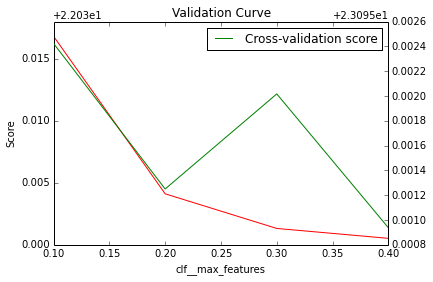

In [10]:
# Plotting the validation curver, i.e. trn/val error versus parameter value
# max_depth = 25
# max_feature = np.arange(0.1, 0.5, 0.1)
# 100% data
print pip.get_params()['steps']
print param_range
print train_scores_mean
print test_scores_mean
plt.title("Validation Curve")
plt.xlabel(param_name)
plt.ylabel("Score")
plt.plot(param_range, train_scores_mean, label="Training score", color="r")
# plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color="r")
plt.twinx()
plt.plot(param_range, test_scores_mean, label="Cross-validation score", color="g")
# plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.2, color="g")
plt.legend(loc="best")
plt.show()

# Different max_feature, sweep max_depth, 100 Tree

[('ttf', TargetThresholdFilter(threshold=45)), ('lpo', LogPlusOne()), ('imp', Imputer(axis=0, copy=False, missing_values='NaN', strategy='median',
    verbose=0)), ('ss', StandardScaler(copy=False, with_mean=True, with_std=True)), ('clf', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=9,
           max_features='sqrt', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=6, oob_score=False, random_state=None,
           verbose=0, warm_start=False))]
[1 2 3 4 5 6 7 8 9]
[ 17.04152724  16.98431267  16.95663769  16.93928294  16.92437963
  16.90802434  16.88785716  16.86231735  16.82957035]
[ 17.04288417  16.98698912  16.96040956  16.945744    16.93663949
  16.92935917  16.92360227  16.92070515  16.91778245]


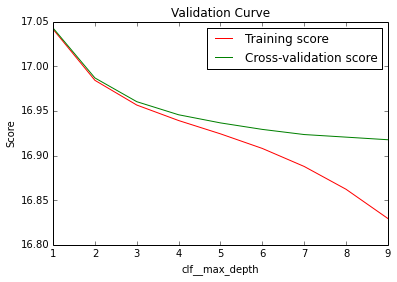

In [25]:
# Plotting the validation curver, i.e. trn/val error versus parameter value
# max_feature = 'sqrt'
# 1% data
print pip.get_params()['steps']
print param_range
print train_scores_mean
print test_scores_mean
plt.title("Validation Curve")
plt.xlabel(param_name)
plt.ylabel("Score")
plt.plot(param_range, train_scores_mean, label="Training score", color="r")
# plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color="r")
plt.plot(param_range, test_scores_mean, label="Cross-validation score", color="g")
# plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.2, color="g")
plt.legend(loc="best")
plt.show()

[('ttf', TargetThresholdFilter(threshold=45)), ('lpo', LogPlusOne()), ('imp', Imputer(axis=0, copy=False, missing_values='NaN', strategy='median',
    verbose=0)), ('ss', StandardScaler(copy=False, with_mean=True, with_std=True)), ('clf', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=19,
           max_features='sqrt', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=6, oob_score=False, random_state=None,
           verbose=0, warm_start=False))]
[10 11 12 13 14 15 16 17 18 19]
[ 16.78936037  16.74134082  16.68502198  16.62068375  16.55242718
  16.48002577  16.40296983  16.32371576  16.24613405  16.17018704]
[ 16.91639953  16.91575418  16.91469049  16.91423752  16.91640889
  16.91645709  16.91924539  16.91804695  16.92010789  16.92507704]


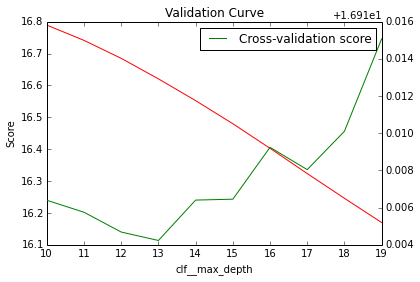

In [30]:
# Plotting the validation curver, i.e. trn/val error versus parameter value
# max_feature = 'sqrt'
# 1% data
print pip.get_params()['steps']
print param_range
print train_scores_mean
print test_scores_mean
plt.title("Validation Curve")
plt.xlabel(param_name)
plt.ylabel("Score")
plt.plot(param_range, train_scores_mean, label="Training score", color="r")
# plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color="r")
plt.twinx()
plt.plot(param_range, test_scores_mean, label="Cross-validation score", color="g")
# plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.2, color="g")
plt.legend(loc="best")
plt.show()

[('ttf', TargetThresholdFilter(threshold=45)), ('lpo', LogPlusOne()), ('imp', Imputer(axis=0, copy=False, missing_values='NaN', strategy='median',
    verbose=0)), ('ss', StandardScaler(copy=False, with_mean=True, with_std=True)), ('clf', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=15,
           max_features='sqrt', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=6, oob_score=False, random_state=None,
           verbose=0, warm_start=False))]
[11 12 13 14 15]
[ 23.06048581  23.01941412  22.9679394   22.90728131  22.8376691 ]
[ 23.13050177  23.12485662  23.11969907  23.11508679  23.11190455]


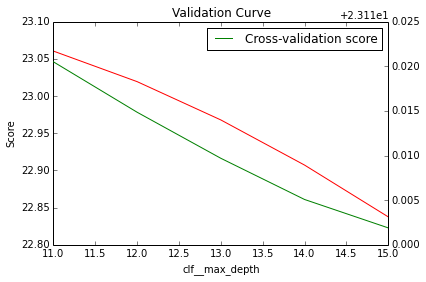

In [39]:
# Plotting the validation curver, i.e. trn/val error versus parameter value
# max_feature = 'sqrt'
# 100% data
print pip.get_params()['steps']
print param_range
print train_scores_mean
print test_scores_mean
plt.title("Validation Curve")
plt.xlabel(param_name)
plt.ylabel("Score")
plt.plot(param_range, train_scores_mean, label="Training score", color="r")
# plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color="r")
plt.twinx()
plt.plot(param_range, test_scores_mean, label="Cross-validation score", color="g")
# plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.2, color="g")
plt.legend(loc="best")
plt.show()

[('ttf', TargetThresholdFilter(threshold=45)), ('lpo', LogPlusOne()), ('imp', Imputer(axis=0, copy=False, missing_values='NaN', strategy='median',
    verbose=0)), ('ss', StandardScaler(copy=False, with_mean=True, with_std=True)), ('clf', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
           max_features='sqrt', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=6, oob_score=False, random_state=None,
           verbose=0, warm_start=False))]
[16 17 18 19 20]
[ 22.76042184  22.67662616  22.59010512  22.50222681  22.41488632]
[ 23.1086172   23.10601557  23.10390696  23.10244429  23.10104218]


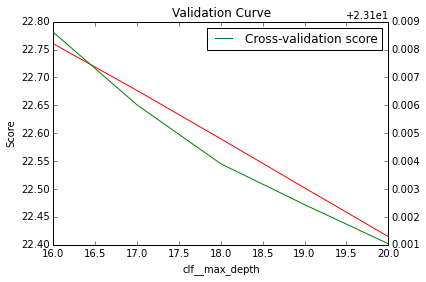

In [41]:
# Plotting the validation curver, i.e. trn/val error versus parameter value
# max_feature = 'sqrt'
# 100% data
print pip.get_params()['steps']
print param_range
print train_scores_mean
print test_scores_mean
plt.title("Validation Curve")
plt.xlabel(param_name)
plt.ylabel("Score")
plt.plot(param_range, train_scores_mean, label="Training score", color="r")
# plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color="r")
plt.twinx()
plt.plot(param_range, test_scores_mean, label="Cross-validation score", color="g")
# plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.2, color="g")
plt.legend(loc="best")
plt.show()

[('ttf', TargetThresholdFilter(threshold=45)), ('lpo', LogPlusOne()), ('imp', Imputer(axis=0, copy=False, missing_values='NaN', strategy='median',
    verbose=0)), ('ss', StandardScaler(copy=False, with_mean=True, with_std=True)), ('clf', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=35,
           max_features='sqrt', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=6, oob_score=False, random_state=None,
           verbose=0, warm_start=False))]
[20 25 30 35]
[ 22.41523738  22.05186688  21.85131254  21.76257873]
[ 23.10100393  23.09793333  23.10056668  23.10062072]


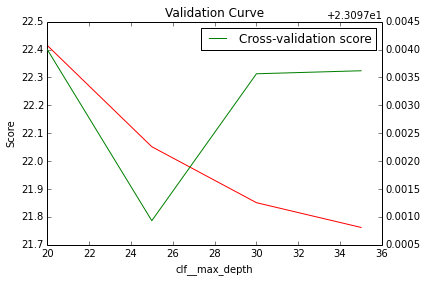

In [43]:
# Plotting the validation curver, i.e. trn/val error versus parameter value
# max_depth = [20 25 30 35]
# max_feature = 'sqrt'
# 100% data
print pip.get_params()['steps']
print param_range
print train_scores_mean
print test_scores_mean
plt.title("Validation Curve")
plt.xlabel(param_name)
plt.ylabel("Score")
plt.plot(param_range, train_scores_mean, label="Training score", color="r")
# plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color="r")
plt.twinx()
plt.plot(param_range, test_scores_mean, label="Cross-validation score", color="g")
# plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.2, color="g")
plt.legend(loc="best")
plt.show()

# Generate submission

In [10]:
pip.fit(X, y)

Pipeline(steps=[('ttf', TargetThresholdFilter(threshold=45)), ('lpo', LogPlusOne()), ('imp', Imputer(axis=0, copy=False, missing_values='NaN', strategy='median',
    verbose=0)), ('ss', StandardScaler(copy=False, with_mean=True, with_std=True)), ('clf', RandomForestRegressor(bootstrap=True, criterion='mse', ...imators=500, n_jobs=6, oob_score=False, random_state=None,
           verbose=0, warm_start=False))])

In [11]:
test = pd.read_csv('../data/test.csv')
test_withRef = test[test['Ref'].notnull()]
test_withRef_comb = test_withRef.groupby('Id').agg(['mean','std','median','count','min', 'max'])
test_withRef_comb.columns = ['_'.join(tup) for (i,tup) in enumerate(test_withRef_comb.columns.values)]
test_X = test_withRef_comb.loc[:, 'minutes_past_mean':'Kdp_5x5_90th_max']  # NOTE: used range slicing on column
test_y_predict = 10**pip.predict(X=test_X)-1

In [12]:
# Ref-samples
test_result_withRef = pd.DataFrame()
test_result_withRef['Id'] = test_withRef_comb.index
test_result_withRef['Expected'] = test_y_predict
# All-samples
test_result = pd.DataFrame()
test_result['Id'] = test['Id'].unique()
# Merge and set Non-Ref samples to -1
test_result = pd.merge(test_result, test_result_withRef, how='left', on=['Id'], sort=True)
test_result.loc[test_result['Expected'].isnull(), 'Expected'] = -1
# Write file
datetime_str = time.strftime('%Y%m%d_%H%M%S')
test_result.to_csv('../data/result_'+datetime_str+'.csv', index=False)
print '../data/result_'+datetime_str+'.csv'

../data/result_20151124_133143.csv
